In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

In [2]:
input_data = "../data/processed/ecg-id-database-1.0.0/Person_01_rec_1.csv"

with open(input_data, "r") as in_data:
    full_dataset = pd.read_csv(in_data)

ecg_data = full_dataset['ECG_I_filtered'].values
ecg_data = pd.Series(ecg_data)

In [5]:
# Select a three-second segment
segment_start = 500  # Choose an appropriate start index
segment_end = segment_start + 3000  # Three seconds at a standard sampling rate

selected_segment = ecg_data[:1080]

# Apply Savitzky-Golay smoothing to the selected segment
smoothed_segment = savgol_filter(selected_segment, window_length=20, polyorder=2)

# Identify R-waves in the smoothed segment
r_waves, _ = find_peaks(smoothed_segment, height=0.45)

# Extract RR intervals from the original segment
rr_intervals = [r_waves[i+1] - r_waves[i] for i in range(len(r_waves)-1)]

# Initialize lists to store wave indices
p_waves, q_waves, s_waves, t_waves = [], [], [], []

# Loop through RR intervals
for i in range(len(rr_intervals)):
    rr_interval = smoothed_segment[r_waves[i]:r_waves[i+1]]

    # Label P and T waves in RR interval
    p_and_t_waves, _ = find_peaks(rr_interval, height=[-0.05, 0.4], distance=350)

    if len(p_and_t_waves) >= 2:
        p_wave = p_and_t_waves[0]
        t_wave = p_and_t_waves[1]
    else:
        # Handle the case when only one peak is found
        p_wave = p_and_t_waves[0]
        t_wave = p_and_t_waves[0]

    # Label Q and S waves
    q_wave = np.argmin(rr_interval[:15])
    s_wave = np.argmin(rr_interval[-15:]) + len(rr_interval) - 15

    # Increment indices
    p_wave += r_waves[i]
    q_wave += r_waves[i]
    s_wave += r_waves[i]
    t_wave += r_waves[i]

    # Append to lists
    p_waves.append(p_wave)
    q_waves.append(q_wave)
    s_waves.append(s_wave)
    t_waves.append(t_wave)

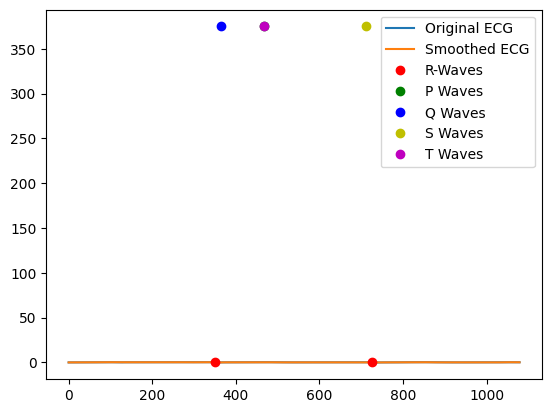

In [6]:
plt.plot(selected_segment, label='Original ECG')
plt.plot(smoothed_segment, label='Smoothed ECG')
plt.plot(r_waves, smoothed_segment[r_waves], 'ro', label='R-Waves')
plt.plot(p_waves, rr_intervals, 'go', label='P Waves')
plt.plot(q_waves, rr_intervals, 'bo', label='Q Waves')
plt.plot(s_waves, rr_intervals, 'yo', label='S Waves')
plt.plot(t_waves, rr_intervals, 'mo', label='T Waves')
plt.legend()
plt.show()